In [53]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

ERROR! Session/line number was not unique in database. History logging moved to new session 842


In [19]:
from datetime import datetime

In [7]:
csv_path = '/Users/pranav/Documents/development/njtransit/csv'

<b>What is the 'business question' I am trying to answer with this analysis?</b>

1) How bad is the morning commute on NJ Transit? <br/>
2) How bad is the morning commute on NJ Transit to New York Penn? <br/>
3) Who had the worst morning commute on NJ Transit in the past two weeks? <br/>
4) A "Day in the Life" of an NJ Transit weekday commuter to NY Penn? --> Fill in station, time (more work) <br/>

# Setup

In [3]:
week1 = ['2018_02_05', '2018_02_06', '2018_02_07', '2018_02_08', '2018_02_09']
week2 = ['2018_02_12', '2018_02_13', '2018_02_14', '2018_02_15', '2018_02_16']
#week3 = ['2018_02_19', '2018_02_20', '2018_02_21', '2018_02_22', '2018_02_23']
weekdays = week1 + week2 #+ week3

In [8]:
weekdays_df = None
for day in weekdays:
    day_df = pd.read_csv('{}/{}.csv'.format(csv_path, day))
    if weekdays_df is None:
        weekdays_df = day_df
    else:
        weekdays_df = weekdays_df.append(day_df, ignore_index=True)

In [14]:
weekdays_df['expected'] = pd.to_datetime(weekdays_df['expected'])
weekdays_df['time'] = pd.to_datetime(weekdays_df['time'])

In [15]:
weekdays_df['delay']=(weekdays_df['time']-weekdays_df['expected']).dt.total_seconds() #calculate delay in seconds
weekdays_df['delay']=(weekdays_df['time']-weekdays_df['expected']).dt.total_seconds() #calculate delay in seconds

In [16]:
def clean_delay(sec):
    if sec < 0:
        return 0
    else:
        return sec
weekdays_df['delay'] = weekdays_df['delay'].apply(lambda x: clean_delay(x))/60.0 # clean delay and get delay in minutes

In [20]:
def get_bucket(dep_time):
    bucket = 15*60 # 15 min. buckets
    dep_day = datetime(year=dep_time.year, month=dep_time.month, day=dep_time.day)
    diff = dep_time - dep_day
    return int(diff.total_seconds() / bucket) * bucket

In [21]:
weekdays_df['bucket'] = weekdays_df['time'].apply(get_bucket)

In [23]:
trains = weekdays_df.groupby(['train_id', 'date'])

In [41]:
delay_by_bucket = trains.last().groupby('bucket')

In [45]:
valid_bucket_delays = delay_by_bucket.filter(lambda x: len(x) >= 50).groupby('bucket')

In [54]:
plt.style.use('ggplot')

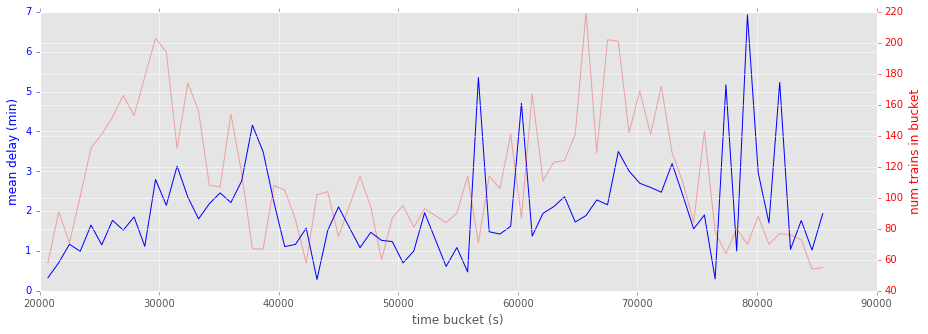

In [72]:
fig, ax = plt.subplots(figsize=(15,5))
delay_mean = valid_bucket_delays['delay'].mean()
delay_mean = delay_mean[delay_mean.index > 900]
sizes = valid_bucket_delays['delay'].size()
sizes = sizes[sizes.index > 900]

ax.plot(delay_mean, 'b-')
ax.set_xlabel('time bucket (s)')
# # Make the y-axis label, ticks and tick labels match the line color.
ax.set_ylabel('mean delay (min)', color='b')
ax.tick_params('y', colors='b')

ax2 = ax.twinx()
# s2 = np.sin(2 * np.pi * t)
ax2.plot(sizes, 'r-', alpha=0.3)
ax2.set_ylabel('num trains in bucket', color='r')
ax2.tick_params('y', colors='r')

# fig.tight_layout()
# plt.show()

In [127]:
trains_last = trains.last()

In [128]:
trains_first = trains.first()

In [129]:
to_nyp = trains_last[(trains_last['type']=="NJ Transit") & (trains_last['to']=="New York Penn Station")].copy()
to_nyp_bucket = to_nyp.groupby('bucket')

In [130]:
from_nyp = trains_first[(trains_first['type']=="NJ Transit") & (trains_first['from']=="New York Penn Station")].copy()
from_nyp_bucket = from_nyp.groupby('bucket')

In [131]:
valid_to_nyp_bucket = to_nyp_bucket.filter(lambda x: len(x) >= 20).groupby('bucket')
valid_from_nyp_bucket = from_nyp_bucket.filter(lambda x: len(x) >= 20).groupby('bucket')


In [138]:
delay_mean_from.index/(3600.0)

Float64Index([ 5.75,   6.0,   6.5,  6.75,   7.0,   7.5,  7.75,   8.0,  8.25,
                8.5,   9.0,  9.25,   9.5,  10.0,  10.5, 13.75,  14.5,  15.0,
               15.5,  16.0, 16.25,  16.5,  17.0, 17.25,  17.5, 17.75,  18.0,
              18.25,  18.5, 18.75,  19.0, 19.25,  19.5,  20.0,  20.5, 20.75,
               21.5, 21.75,  22.0],
             dtype='float64', name=u'bucket')

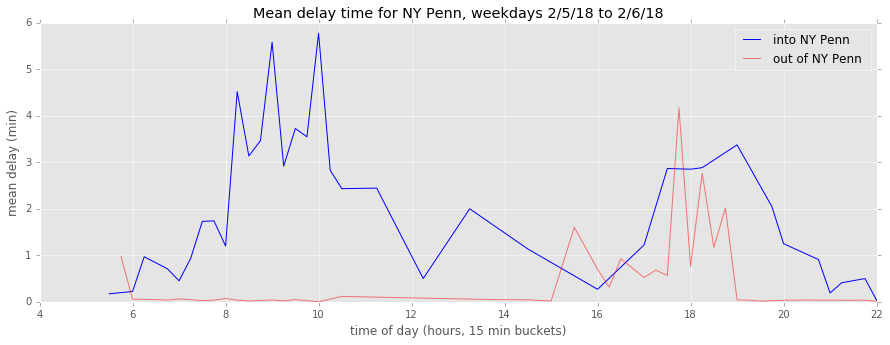

In [142]:
fig, ax = plt.subplots(figsize=(15,5))
delay_mean = valid_to_nyp_bucket['delay'].mean()
delay_mean = delay_mean[delay_mean.index > 900]
delay_mean_from = valid_from_nyp_bucket['delay'].mean()
delay_mean_from = delay_mean_from[delay_mean_from.index > 900]


to_line = ax.plot(delay_mean.index/(3600.0), delay_mean, 'b-', label="delay into NY Penn")
ax.set_xlabel('time of day (hours, 15 min buckets)')
# # Make the y-axis label, ticks and tick labels match the line color.
ax.set_ylabel('mean delay (min)')
ax.tick_params('y')

# # s2 = np.sin(2 * np.pi * t)
from_line = ax.plot(delay_mean_from.index/(3600.0), delay_mean_from, 'r-', alpha=0.5)
# ax2.set_ylabel('num trains in bucket', color='r')
# ax2.tick_params('y', colors='r')
ax.legend(['into NY Penn', 'out of NY Penn '])

ax.set(title='Mean delay time for NY Penn, weekdays 2/5/18 to 2/6/18')

- Percent trains delayed for bucket --> small, heavy
- Percent trains delayed 